
Rastrigin: 2D


In [1]:
pip install pyGPGO


  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19879 sha256=c796b08df726c19e6bb0c48bb580d1e2a6855270ed4003d5b00f1e247c83200a
  Stored in directory: /root/.cache/pip/wheels/c8/5d/0b/2160114e2f1b87791c51b66cf07f89831dbb6f49167950316f
Successfully built pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import solve, cholesky
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.stats import norm
import time

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
### Inputs:

func = 'Rastrigin'
n_test = 500
eps = 1e-08

util_grad_exact = 'dERM_GP'
util_grad_approx = 'ExpectedRegret'

n_init = 5 # random initialisations
iters = 20
opt = True

In [4]:
### Objective Function - Rastrigin(x) 2-D:

def objfunc(x1_training, x2_training):
        return  operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
        
def objfunc_der(x1_training, x2_training):
        return  operator * (2 * x1_training + 20 * np.pi * np.sin(2 * np.pi * x1_training)
                                    + 2 * x2_training + 20 * np.pi * np.sin(2 * np.pi * x2_training)
                          )
    
# Constraints:
lb = -5.12 
ub = +5.12
    
# Input array dimension(s):
dim = 2

# 2-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# True y bounds:
operator = -1
y_global_orig = 0 # targets global minimum

# Test data:
x1_test = np.linspace(lb, ub, n_test) 
x2_test = np.linspace(lb, ub, n_test)
  
x_test = np.column_stack((x1_test,x2_test))


In [5]:
n_start_AcqFunc = iters


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
### Surrogate derivatives: 

cov_func = squaredExponential()

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds
        

In [8]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedRegret': self.ExpectedRegret,
            'dERM_GP': self.dERM_GP
        }

        self.f = mode_dict[mode]
    
    def ExpectedRegret(self, tau, mean, std):
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return (mean - y_global_orig) * norm.cdf(z) + std * norm.pdf(z)[0]


    def dERM_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [9]:
## GPGO_multi: Multistart changed to variable 'n_start_AcqFunc'

class GPGO_multi(GPGO):
    n_start = n_start_AcqFunc

    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.best = x_best[np.argmin(f_best)]

In [10]:
## dGPGO:

grad = 1

class dGPGO(GPGO):
    n_start = n_start_AcqFunc

    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df * grad


In [11]:
###Reproducible set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [12]:
start_approx = time.time()
start_approx


1643279134.7506046

In [13]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = GPGO_multi(surrogate_approx_1, Acquisition_new(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84969467  2.25612281]. 	  -20.33436270766351 	 -19.908403246996286
init   	 [-5.1188288  -2.02411446]. 	  -33.07414982069084 	 -19.908403246996286
init   	 [-3.61721968 -4.17445279]. 	  -53.347974723929894 	 -19.908403246996286
init   	 [-3.21269544 -1.58145816]. 	  -39.218472310354045 	 -19.908403246996286
init   	 [-1.05710106  0.39748336]. 	  -19.908403246996286 	 -19.908403246996286
1      	 [ 4.04077223 -4.24914728]. 	  -44.655863836006326 	 -19.908403246996286
2      	 [4.64028151 5.12      ]. 	  -66.81752730899376 	 -19.908403246996286
3      	 [-5.12  5.12]. 	  -57.849427451571785 	 -19.908403246996286
4      	 [5.12       0.33809582]. 	  -44.29589120518327 	 -19.908403246996286
5      	 [ 0.22553122 -5.12      ]. 	  -37.4442083812247 	 -19.908403246996286
6      	 [0.75630513 5.12      ]. 	  -39.100651914461935 	 -19.908403246996286
7      	 [ 1.73165733 -1.39031839]. 	  -33.79944486006294 	 -19.90840324699

In [14]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = GPGO_multi(surrogate_approx_2, Acquisition_new(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.6554122  -4.85451539]. 	  -43.490296251903594 	 -18.964539418712707
init   	 [ 0.50854377 -0.6622987 ]. 	  -35.91861667536101 	 -18.964539418712707
init   	 [-0.81543371 -1.73737143]. 	  -20.479562046739524 	 -18.964539418712707
init   	 [-3.02439799  1.2213347 ]. 	  -18.964539418712707 	 -18.964539418712707
init   	 [-2.05153614 -2.3876887 ]. 	  -28.041315668371354 	 -18.964539418712707
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
2      	 [4.77484577 5.12      ]. 	  -60.169093311219 	 -18.964539418712707
3      	 [-0.33018751  5.12      ]. 	  -43.86159508626071 	 -18.964539418712707
4      	 [5.12       0.08035632]. 	  -30.17891149546477 	 -18.964539418712707
5      	 [-5.12  5.12]. 	  -57.849427451571785 	 -18.964539418712707
6      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
7      	 [2.21222967 2.42058184]. 	  -37.182830503110985 	 -18.964539418712707
8      	 [-5.12   

In [15]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = GPGO_multi(surrogate_approx_3, Acquisition_new(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52017052 2.1314337 ]. 	  -27.953858411008774 	 -10.607662635789808
init   	 [-2.14113547  0.11087468]. 	  -10.607662635789808 	 -10.607662635789808
init   	 [4.02377681 4.05804123]. 	  -33.42749829480097 	 -10.607662635789808
init   	 [-3.83400642 -2.99783293]. 	  -28.650953928965198 	 -10.607662635789808
init   	 [-4.59297584 -0.6061072 ]. 	  -57.6631355589384 	 -10.607662635789808
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -10.607662635789808
2      	 [-4.61904204  5.12      ]. 	  -67.59102009462822 	 -10.607662635789808
3      	 [ 5.12       -0.40159891]. 	  -47.234806525771404 	 -10.607662635789808
4      	 [ 0.29071736 -5.12      ]. 	  -41.53976060750644 	 -10.607662635789808
5      	 [ 1.34927722 -1.51093783]. 	  -39.92092770530185 	 -10.607662635789808
6      	 [-0.80321914  5.12      ]. 	  -36.28798476592165 	 -10.607662635789808
7      	 [-2.83254219  2.46988965]. 	  -38.98833187418504 	 -10.6076626357

In [16]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = GPGO_multi(surrogate_approx_4, Acquisition_new(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.78238555 0.48365823]. 	  -51.03163809010808 	 -14.323038259018315
init   	 [4.84028785 2.19971578]. 	  -39.78645699016559 	 -14.323038259018315
init   	 [ 2.02474316 -2.90724357]. 	  -14.323038259018315 	 -14.323038259018315
init   	 [ 4.87705042 -5.05620219]. 	  -52.80627247106233 	 -14.323038259018315
init   	 [-2.52946061 -0.66773471]. 	  -41.61497868486559 	 -14.323038259018315
1      	 [-0.75213717  4.73292922]. 	  -43.90258428635684 	 -14.323038259018315
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -14.323038259018315
3      	 [-5.12        3.36771998]. 	  -57.0065931877583 	 -14.323038259018315
4      	 [-0.95956457 -5.12      ]. 	  -30.16648642810128 	 -14.323038259018315
5      	 [0.89090861 1.10665806]. 	  -6.439742827630441 	 -6.439742827630441
6      	 [2.95832758 5.12      ]. 	  -38.01725113264108 	 -6.439742827630441
7      	 [-5.12       -1.83363717]. 	  -37.2704152332493 	 -6.439742827630441
8    

In [17]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_approx_5 = GaussianProcess(cov_func, optimize=opt)

approx_5 = GPGO_multi(surrogate_approx_5, Acquisition_new(util_grad_approx), objfunc, param)
approx_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.84678993  3.79629882]. 	  -33.93442008827236 	 -7.8108627039749745
init   	 [-3.00319585  4.2865757 ]. 	  -39.673876075575784 	 -7.8108627039749745
init   	 [-0.11866943  1.14425716]. 	  -7.8108627039749745 	 -7.8108627039749745
init   	 [2.72289645 0.1886002 ]. 	  -25.38160395721669 	 -7.8108627039749745
init   	 [-2.08076286 -3.19773462]. 	  -22.589982116319675 	 -7.8108627039749745
1      	 [ 5.12       -4.82910414]. 	  -57.47682591577337 	 -7.8108627039749745
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -7.8108627039749745
3      	 [-5.12       -0.04624623]. 	  -29.346055646927017 	 -7.8108627039749745
4      	 [1.00367618 5.12      ]. 	  -29.934747080138813 	 -7.8108627039749745
5      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.8108627039749745
6      	 [ 1.10695801 -5.12      ]. 	  -32.324518858419424 	 -7.8108627039749745
7      	 [ 5.12       -1.43814139]. 	  -50.24710665015467 	 -7.8108627039749745
8   

In [18]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_approx_6 = GaussianProcess(cov_func, optimize=opt)

approx_6 = GPGO_multi(surrogate_approx_6, Acquisition_new(util_grad_approx), objfunc, param)
approx_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.02288795 -1.72052679]. 	  -31.08835710146886 	 -17.28954482757088
init   	 [ 3.28938622 -4.69302655]. 	  -58.797867722203385 	 -17.28954482757088
init   	 [-4.0175956   0.97333314]. 	  -17.28954482757088 	 -17.28954482757088
init   	 [ 0.30532979 -0.83141193]. 	  -19.296253155889353 	 -17.28954482757088
init   	 [-1.68542362  1.25459899]. 	  -28.650630936276173 	 -17.28954482757088
1      	 [-3.50682913 -4.82182882]. 	  -61.17719800274786 	 -17.28954482757088
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -17.28954482757088
3      	 [-5.12  5.12]. 	  -57.849427451571785 	 -17.28954482757088
4      	 [0.39543546 5.12      ]. 	  -46.999373090619045 	 -17.28954482757088
5      	 [2.8423059  1.91250897]. 	  -17.72966633001967 	 -17.28954482757088
6      	 [-5.12       -1.80313796]. 	  -38.89894920549178 	 -17.28954482757088
7      	 [-0.11793256 -4.27602974]. 	  -32.548561739375906 	 -17.28954482757088
8      	 [5.12   

In [19]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_approx_7 = GaussianProcess(cov_func, optimize=opt)

approx_7 = GPGO_multi(surrogate_approx_7, Acquisition_new(util_grad_approx), objfunc, param)
approx_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.33860312  2.86636843]. 	  -45.646133072936244 	 -22.52235437888213
init   	 [-0.63068947  2.28828342]. 	  -34.83012662845338 	 -22.52235437888213
init   	 [4.8946126  0.39419771]. 	  -44.09657005662876 	 -22.52235437888213
init   	 [ 0.01147355 -4.38219639]. 	  -36.613209822404315 	 -22.52235437888213
init   	 [-2.37118484e+00 -1.20319155e-03]. 	  -22.52235437888213 	 -22.52235437888213
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
3      	 [3.59148274 5.12      ]. 	  -60.216456152688124 	 -22.52235437888213
4      	 [-4.02558214 -1.33646422]. 	  -33.289738493146906 	 -22.52235437888213
5      	 [ 1.40596234 -0.96124897]. 	  -21.500321781402842 	 -21.500321781402842
6      	 [-1.80774681  5.12      ]. 	  -38.64341172628781 	 -21.500321781402842
7      	 [2.33744232 2.13046197]. 	  -28.40011689272525 	 -21.500321781402842
8     

In [20]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_approx_8 = GaussianProcess(cov_func, optimize=opt)

approx_8 = GPGO_multi(surrogate_approx_8, Acquisition_new(util_grad_approx), objfunc, param)
approx_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.82391708 4.79785639]. 	  -50.20079446939181 	 -13.871821018360485
init   	 [3.78055209 0.31596228]. 	  -36.5114251593508 	 -13.871821018360485
init   	 [-2.73686192 -5.00327624]. 	  -43.34985765011677 	 -13.871821018360485
init   	 [-0.7119993  -0.99992207]. 	  -13.871821018360485 	 -13.871821018360485
init   	 [ 0.23218863 -0.22126801]. 	  -17.190590355445654 	 -13.871821018360485
1      	 [-3.08049418  4.13284171]. 	  -31.107529727094295 	 -13.871821018360485
2      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -13.871821018360485
3      	 [-5.12       -0.39982603]. 	  -47.168314618373735 	 -13.871821018360485
4      	 [ 1.18398246 -4.40957112]. 	  -45.244868241394975 	 -13.871821018360485
5      	 [0.42088125 3.28854336]. 	  -42.179413920587116 	 -13.871821018360485
6      	 [-2.38772959  1.21881037]. 	  -32.85298868042359 	 -13.871821018360485
7      	 [ 5.12       -2.11274933]. 	  -35.79454727217525 	 -13.8718210183

In [21]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_approx_9 = GaussianProcess(cov_func, optimize=opt)

approx_9 = GPGO_multi(surrogate_approx_9, Acquisition_new(util_grad_approx), objfunc, param)
approx_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.01376866  0.01919582]. 	  -25.248289026162446 	 -24.454800313488693
init   	 [-0.04328148 -3.74958562]. 	  -24.454800313488693 	 -24.454800313488693
init   	 [-3.66478248 -2.88195916]. 	  -39.46509426509438 	 -24.454800313488693
init   	 [-0.83447623 -2.57944404]. 	  -31.06766397812992 	 -24.454800313488693
init   	 [-4.25922917 -1.58209393]. 	  -49.922543556206975 	 -24.454800313488693
1      	 [3.69491889 4.82146316]. 	  -55.95031066333101 	 -24.454800313488693
2      	 [-2.19884748  5.08680517]. 	  -39.002426583702 	 -24.454800313488693
3      	 [ 5.10452216 -0.68397541]. 	  -42.63453098314871 	 -24.454800313488693
4      	 [ 4.49553512 -5.12      ]. 	  -69.13061496361522 	 -24.454800313488693
5      	 [0.62467974 1.48438828]. 	  -39.6308447203286 	 -24.454800313488693
6      	 [-5.12        3.40866689]. 	  -58.94182561458615 	 -24.454800313488693
7      	 [ 2.19603187 -1.69761718]. 	  -27.610360693384305 	 -24.4

In [22]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_approx_10 = GaussianProcess(cov_func, optimize=opt)

approx_10 = GPGO_multi(surrogate_approx_10, Acquisition_new(util_grad_approx), objfunc, param)
approx_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.77832339 -4.90750004]. 	  -41.674330194390116 	 -13.839458310244165
init   	 [1.36855793 2.54775176]. 	  -44.69639719065837 	 -13.839458310244165
init   	 [-0.01528819 -2.81808235]. 	  -13.839458310244165 	 -13.839458310244165
init   	 [-3.09183626  2.66783449]. 	  -33.23221510904937 	 -13.839458310244165
init   	 [-3.38830503 -4.2154003 ]. 	  -54.73014366983691 	 -13.839458310244165
1      	 [ 5.12       -0.56860392]. 	  -48.33329462653664 	 -13.839458310244165
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -13.839458310244165
3      	 [-5.12       -0.60617914]. 	  -47.14809173422459 	 -13.839458310244165
4      	 [-5.12  5.12]. 	  -57.849427451571785 	 -13.839458310244165
5      	 [-0.83793555  5.12      ]. 	  -34.37854972204409 	 -13.839458310244165
6      	 [-1.23133194 -0.10555144]. 	  -12.476791500721827 	 -12.476791500721827
7      	 [ 1.89650273 -0.79267969]. 	  -13.616377620323334 	 -12.476791500721827
8   

In [23]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_approx_11 = GaussianProcess(cov_func, optimize=opt)

approx_11 = GPGO_multi(surrogate_approx_11, Acquisition_new(util_grad_approx), objfunc, param)
approx_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.27403839 -4.92057353]. 	  -47.655641290890955 	 -10.679755252484755
init   	 [-0.37664229  2.30332343]. 	  -35.87889240695259 	 -10.679755252484755
init   	 [-0.81711509 -0.14922651]. 	  -10.679755252484755 	 -10.679755252484755
init   	 [-4.98912446 -0.12931474]. 	  -28.05462905574235 	 -10.679755252484755
init   	 [4.52410012 3.59214172]. 	  -71.62694632141611 	 -10.679755252484755
1      	 [ 3.73200785 -5.12      ]. 	  -53.98067014717985 	 -10.679755252484755
2      	 [-5.12  5.12]. 	  -57.849427451571785 	 -10.679755252484755
3      	 [ 5.12       -0.89340857]. 	  -31.88302241474738 	 -10.679755252484755
4      	 [ 0.31356402 -3.36750127]. 	  -42.05708481864723 	 -10.679755252484755
5      	 [1.20983398 5.12      ]. 	  -37.89141107596778 	 -10.679755252484755
6      	 [2.15080963 0.11826982]. 	  -11.439676550889681 	 -10.679755252484755
7      	 [-1.93524339  5.12      ]. 	  -33.4862718263164 	 -10.6797552524847

In [24]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_approx_12 = GaussianProcess(cov_func, optimize=opt)

approx_12 = GPGO_multi(surrogate_approx_12, Acquisition_new(util_grad_approx), objfunc, param)
approx_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.54137249  2.45810889]. 	  -57.903242869085595 	 -40.51116653209555
init   	 [-2.42365424  0.34549139]. 	  -40.51116653209555 	 -40.51116653209555
init   	 [-4.97075238  4.28796936]. 	  -55.62655915398208 	 -40.51116653209555
init   	 [ 4.10332011 -4.77776458]. 	  -49.962803461970296 	 -40.51116653209555
init   	 [ 4.6791612  -3.71497655]. 	  -62.183891474990624 	 -40.51116653209555
1      	 [4.12828398 5.12      ]. 	  -49.04377260896486 	 -40.51116653209555
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -40.51116653209555
3      	 [2.40876004 0.58851143]. 	  -43.04277302743077 	 -40.51116653209555
4      	 [-0.48694043 -4.12694144]. 	  -40.25082195724219 	 -40.25082195724219
5      	 [-5.12       -1.54445324]. 	  -50.92251417551503 	 -40.25082195724219
6      	 [-0.17351919  5.12      ]. 	  -34.33221432232489 	 -34.33221432232489
7      	 [5.12       1.93231879]. 	  -33.54922824417045 	 -33.54922824417045
8      	

In [25]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_approx_13 = GaussianProcess(cov_func, optimize=opt)

approx_13 = GPGO_multi(surrogate_approx_13, Acquisition_new(util_grad_approx), objfunc, param)
approx_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.84367268 -2.68757791]. 	  -33.58019830007169 	 -17.435826639425656
init   	 [3.32061217 4.76927179]. 	  -56.857057997503354 	 -17.435826639425656
init   	 [ 4.83943541 -0.47667971]. 	  -48.211919361679726 	 -17.435826639425656
init   	 [1.11659482 2.82139151]. 	  -17.435826639425656 	 -17.435826639425656
init   	 [1.45012065 2.27346667]. 	  -38.25352329493884 	 -17.435826639425656
1      	 [-4.10876704 -2.60547476]. 	  -43.79941556238635 	 -17.435826639425656
2      	 [-4.210207    3.16126079]. 	  -39.95389880951034 	 -17.435826639425656
3      	 [-0.62130064 -5.12      ]. 	  -46.544229285892115 	 -17.435826639425656
4      	 [-0.72633021 -0.82502427]. 	  -18.148697146605524 	 -17.435826639425656
5      	 [-1.0340358  5.12     ]. 	  -30.221739637636595 	 -17.435826639425656
6      	 [-5.12        0.27694188]. 	  -40.686145793284986 	 -17.435826639425656
7      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -17.4358266394

In [26]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_approx_14 = GaussianProcess(cov_func, optimize=opt)

approx_14 = GPGO_multi(surrogate_approx_14, Acquisition_new(util_grad_approx), objfunc, param)
approx_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.14277984 2.79721013]. 	  -18.683085263052178 	 -10.423838604848608
init   	 [ 3.7931795  -5.03759925]. 	  -47.36348784446708 	 -10.423838604848608
init   	 [-1.94830412  4.68586229]. 	  -40.19779334078636 	 -10.423838604848608
init   	 [ 0.13431513 -1.86076749]. 	  -10.423838604848608 	 -10.423838604848608
init   	 [ 0.40140736 -2.85434939]. 	  -30.353548735049138 	 -10.423838604848608
1      	 [-4.98693264 -1.05452915]. 	  -26.596428006897547 	 -10.423838604848608
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -10.423838604848608
3      	 [ 5.12       -0.06387262]. 	  -29.723345629311133 	 -10.423838604848608
4      	 [-3.5633238 -5.12     ]. 	  -60.8408538559967 	 -10.423838604848608
5      	 [-1.85186527  0.20590279]. 	  -14.7641440279331 	 -10.423838604848608
6      	 [-5.12        2.75339211]. 	  -46.292765573980496 	 -10.423838604848608
7      	 [1.8898502  0.23394118]. 	  -14.919838460614862 	 -10.423838604848

In [27]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_approx_15 = GaussianProcess(cov_func, optimize=opt)

approx_15 = GPGO_multi(surrogate_approx_15, Acquisition_new(util_grad_approx), objfunc, param)
approx_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.57189322 -3.28810573]. 	  -54.938487770767075 	 -7.990765314336182
init   	 [-4.56332069 -1.41784631]. 	  -60.750198753157726 	 -7.990765314336182
init   	 [-2.29989449  0.3072023 ]. 	  -31.984997246800887 	 -7.990765314336182
init   	 [-1.9873903  -2.00218256]. 	  -7.990765314336182 	 -7.990765314336182
init   	 [-3.97576933 -2.5610341 ]. 	  -41.754957769694336 	 -7.990765314336182
1      	 [5.12      4.8007629]. 	  -58.83631552706962 	 -7.990765314336182
2      	 [-5.12      5.068432]. 	  -55.52393816380152 	 -7.990765314336182
3      	 [0.00795356 5.12      ]. 	  -28.937261227682868 	 -7.990765314336182
4      	 [2.25293715 1.11070296]. 	  -18.817019042331907 	 -7.990765314336182
5      	 [-0.33197535 -5.12      ]. 	  -43.96084683626894 	 -7.990765314336182
6      	 [5.12       0.08147475]. 	  -30.213300455194748 	 -7.990765314336182
7      	 [ 0.59198955 -1.56889437]. 	  -40.26515083237238 	 -7.990765314336182
8

In [28]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_approx_16 = GaussianProcess(cov_func, optimize=opt)

approx_16 = GPGO_multi(surrogate_approx_16, Acquisition_new(util_grad_approx), objfunc, param)
approx_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.83349935  0.23719262]. 	  -22.27210456874814 	 -22.27210456874814
init   	 [ 0.51918292 -4.65303603]. 	  -57.57021076017139 	 -22.27210456874814
init   	 [-1.42613673 -2.83565116]. 	  -33.89145899403749 	 -22.27210456874814
init   	 [ 1.9325559  -3.44339021]. 	  -35.85029586225333 	 -22.27210456874814
init   	 [-4.39987336  4.51595121]. 	  -77.78800881964571 	 -22.27210456874814
1      	 [2.142749   4.83374619]. 	  -36.69381850109535 	 -22.27210456874814
2      	 [5.12       0.59289917]. 	  -47.620520561702925 	 -22.27210456874814
3      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
4      	 [1.00686592 0.83549834]. 	  -6.603799654593312 	 -6.603799654593312
5      	 [-0.94229218  3.24295449]. 	  -21.612313565214063 	 -6.603799654593312
6      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -6.603799654593312
7      	 [-5.12       -1.65377245]. 	  -47.34413519198449 	 -6.603799654593312
8      	 [5.12      

In [29]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_approx_17 = GaussianProcess(cov_func, optimize=opt)

approx_17 = GPGO_multi(surrogate_approx_17, Acquisition_new(util_grad_approx), objfunc, param)
approx_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.10263037  0.31320838]. 	  -20.395145364684023 	 -20.395145364684023
init   	 [-3.15882714 -4.42470033]. 	  -53.03732051200137 	 -20.395145364684023
init   	 [2.93873111 1.60085526]. 	  -29.989224812583537 	 -20.395145364684023
init   	 [1.40821398 0.77417363]. 	  -29.451989415882437 	 -20.395145364684023
init   	 [-4.71999574 -1.45598869]. 	  -55.89242173757483 	 -20.395145364684023
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -20.395145364684023
2      	 [-4.70696357  5.12      ]. 	  -63.75144562567341 	 -20.395145364684023
3      	 [0.05624733 5.12      ]. 	  -29.545906146758426 	 -20.395145364684023
4      	 [5.12 5.12]. 	  -57.849427451571785 	 -20.395145364684023
5      	 [ 1.077264   -3.51432684]. 	  -34.62591651354173 	 -20.395145364684023
6      	 [ 5.12     -1.253805]. 	  -40.735792813734875 	 -20.395145364684023
7      	 [-5.12        1.83143795]. 	  -37.382366135599646 	 -20.395145364684023
8      	 [

In [30]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_approx_18 = GaussianProcess(cov_func, optimize=opt)

approx_18 = GPGO_multi(surrogate_approx_18, Acquisition_new(util_grad_approx), objfunc, param)
approx_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53983224 0.05584255]. 	  -22.67190580753611 	 -22.67190580753611
init   	 [ 3.87687906 -3.25795609]. 	  -38.990099416711985 	 -22.67190580753611
init   	 [3.60686662 2.56139557]. 	  -56.66448698782129 	 -22.67190580753611
init   	 [1.70088108 4.99604939]. 	  -40.894059318256296 	 -22.67190580753611
init   	 [-2.48864335 -4.83014733]. 	  -54.6725749848372 	 -22.67190580753611
1      	 [-5.00718904  2.9174042 ]. 	  -34.91005808676357 	 -22.67190580753611
2      	 [-5.12       -1.37222114]. 	  -47.75423927503102 	 -22.67190580753611
3      	 [-1.30205533  2.41793749]. 	  -39.45439977588798 	 -22.67190580753611
4      	 [ 1.04804663 -5.12      ]. 	  -30.475340813935276 	 -22.67190580753611
5      	 [-1.46191306 -1.336791  ]. 	  -38.82617470809004 	 -22.67190580753611
6      	 [-2.73822047  5.12      ]. 	  -47.16201908944714 	 -22.67190580753611
7      	 [ 5.12       -0.35162333]. 	  -45.00841525498375 	 -22.6719058075361

In [31]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_approx_19 = GaussianProcess(cov_func, optimize=opt)

approx_19 = GPGO_multi(surrogate_approx_19, Acquisition_new(util_grad_approx), objfunc, param)
approx_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.12125592  2.6751971 ]. 	  -41.43485596167127 	 -25.867003842388073
init   	 [-2.59135515 -3.70553152]. 	  -51.60126035043229 	 -25.867003842388073
init   	 [-1.72598719 -4.27008445]. 	  -43.97430127029199 	 -25.867003842388073
init   	 [1.76104531 3.13952049]. 	  -25.867003842388073 	 -25.867003842388073
init   	 [4.9432772  1.38916592]. 	  -44.66580306903559 	 -25.867003842388073
1      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -25.867003842388073
2      	 [ 1.77619464 -1.68663335]. 	  -28.238247751547107 	 -25.867003842388073
3      	 [5.12 5.12]. 	  -57.849427451571785 	 -25.867003842388073
4      	 [-1.28669736  5.12      ]. 	  -42.86569018501187 	 -25.867003842388073
5      	 [-5.12       -0.97841384]. 	  -29.973843760306124 	 -25.867003842388073
6      	 [-1.20053384  0.35650887]. 	  -24.713832493597153 	 -24.713832493597153
7      	 [ 1.5401455 -5.12     ]. 	  -50.980315881073935 	 -24.713832493597153
8      

In [32]:
### ESTIMATED GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_approx_20 = GaussianProcess(cov_func, optimize=opt)

approx_20 = GPGO_multi(surrogate_approx_20, Acquisition_new(util_grad_approx), objfunc, param)
approx_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.9024594  4.07258857]. 	  -20.24255447774017 	 -17.388691338534382
init   	 [4.00927467 3.23417577]. 	  -35.55852254546393 	 -17.388691338534382
init   	 [-4.75249064  1.96359764]. 	  -36.54582989269194 	 -17.388691338534382
init   	 [-1.24230715  0.18955208]. 	  -17.388691338534382 	 -17.388691338534382
init   	 [ 1.61742301 -3.13497377]. 	  -33.22932870179905 	 -17.388691338534382
1      	 [-5.12       -3.80676527]. 	  -49.924648969758294 	 -17.388691338534382
2      	 [ 5.12       -0.92644504]. 	  -30.832096866887802 	 -17.388691338534382
3      	 [ 5.12 -5.12]. 	  -57.849427451571785 	 -17.388691338534382
4      	 [-2.703692  5.12    ]. 	  -49.10340102448606 	 -17.388691338534382
5      	 [-1.50460778 -5.12      ]. 	  -51.18436762764294 	 -17.388691338534382
6      	 [1.91189042 0.46615145]. 	  -25.140989370455223 	 -17.388691338534382
7      	 [-3.79264529 -1.02036442]. 	  -22.85951596461122 	 -17.388691338534382

In [33]:
end_approx = time.time()
end_approx

time_approx = end_approx - start_approx
time_approx

start_exact = time.time()
start_exact

1643279262.0333285

In [34]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.84969467  2.25612281]. 	  -20.33436270766351 	 -19.908403246996286
init   	 [-5.1188288  -2.02411446]. 	  -33.07414982069084 	 -19.908403246996286
init   	 [-3.61721968 -4.17445279]. 	  -53.347974723929894 	 -19.908403246996286
init   	 [-3.21269544 -1.58145816]. 	  -39.218472310354045 	 -19.908403246996286
init   	 [-1.05710106  0.39748336]. 	  -19.908403246996286 	 -19.908403246996286
1      	 [ 4.04077223 -4.24914728]. 	  -44.655863836006326 	 -19.908403246996286
2      	 [3.95569971 5.12      ]. 	  -44.957164327661914 	 -19.908403246996286
3      	 [5.12       0.47931867]. 	  -49.070150846574705 	 -19.908403246996286
4      	 [-5.12        4.36680096]. 	  -64.69123843791516 	 -19.908403246996286
5      	 [ 0.20333181 -5.12      ]. 	  -36.075648170413245 	 -19.908403246996286
6      	 [ 1.75432371 -1.381871  ]. 	  -32.085240989199335 	 -19.908403246996286
7      	 [0.30219617 5.12      ]. 	  -42.2371437744485 	 -

In [35]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-0.6554122  -4.85451539]. 	  -43.490296251903594 	 -18.964539418712707
init   	 [ 0.50854377 -0.6622987 ]. 	  -35.91861667536101 	 -18.964539418712707
init   	 [-0.81543371 -1.73737143]. 	  -20.479562046739524 	 -18.964539418712707
init   	 [-3.02439799  1.2213347 ]. 	  -18.964539418712707 	 -18.964539418712707
init   	 [-2.05153614 -2.3876887 ]. 	  -28.041315668371354 	 -18.964539418712707
1      	 [3.91207732 5.12      ]. 	  -45.71656758082061 	 -18.964539418712707
2      	 [ 4.84262143 -3.96515559]. 	  -43.91554200116249 	 -18.964539418712707
3      	 [-0.81906025  5.12      ]. 	  -35.39128099260596 	 -18.964539418712707
4      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -18.964539418712707
5      	 [5.12       0.71181662]. 	  -41.80757997921044 	 -18.964539418712707
6      	 [-4.6297519   4.23289614]. 	  -65.13623895313233 	 -18.964539418712707
7      	 [1.67424765 2.45754179]. 	  -43.070856732743444 	 -18.9645394187

In [36]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.52017052 2.1314337 ]. 	  -27.953858411008774 	 -10.607662635789808
init   	 [-2.14113547  0.11087468]. 	  -10.607662635789808 	 -10.607662635789808
init   	 [4.02377681 4.05804123]. 	  -33.42749829480097 	 -10.607662635789808
init   	 [-3.83400642 -2.99783293]. 	  -28.650953928965198 	 -10.607662635789808
init   	 [-4.59297584 -0.6061072 ]. 	  -57.6631355589384 	 -10.607662635789808
1      	 [ 1.80565001 -3.04761061]. 	  -19.5666404549755 	 -10.607662635789808
2      	 [-3.57871734  4.80548253]. 	  -61.28559802785689 	 -10.607662635789808
3      	 [ 5.12       -0.22832109]. 	  -37.61892634098505 	 -10.607662635789808
4      	 [-0.98127961 -5.12      ]. 	  -29.95672032642291 	 -10.607662635789808
5      	 [-0.58862849 -1.88989711]. 	  -24.70632438438374 	 -10.607662635789808
6      	 [ 5.12       -4.57451492]. 	  -68.77476117581725 	 -10.607662635789808
7      	 [0.4944958 5.12     ]. 	  -49.16326018401635 	 -10.60766

In [37]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.78238555 0.48365823]. 	  -51.03163809010808 	 -14.323038259018315
init   	 [4.84028785 2.19971578]. 	  -39.78645699016559 	 -14.323038259018315
init   	 [ 2.02474316 -2.90724357]. 	  -14.323038259018315 	 -14.323038259018315
init   	 [ 4.87705042 -5.05620219]. 	  -52.80627247106233 	 -14.323038259018315
init   	 [-2.52946061 -0.66773471]. 	  -41.61497868486559 	 -14.323038259018315
1      	 [-1.01565322  4.77412453]. 	  -32.362152132578984 	 -14.323038259018315
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -14.323038259018315
3      	 [-0.96892694 -5.12      ]. 	  -30.053517501182938 	 -14.323038259018315
4      	 [0.8312782 1.3534401]. 	  -23.686398382791584 	 -14.323038259018315
5      	 [-5.12        3.19466591]. 	  -45.72348149433703 	 -14.323038259018315
6      	 [4.10247948 5.12      ]. 	  -47.75743112638065 	 -14.323038259018315
7      	 [-5.12      -1.8440995]. 	  -36.751468915848136 	 -14.323038259018315


In [38]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=opt)

exact_5 = dGPGO(surrogate_exact_5, Acquisition_new(util_grad_exact), objfunc, param)
exact_5.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.84678993  3.79629882]. 	  -33.93442008827236 	 -7.8108627039749745
init   	 [-3.00319585  4.2865757 ]. 	  -39.673876075575784 	 -7.8108627039749745
init   	 [-0.11866943  1.14425716]. 	  -7.8108627039749745 	 -7.8108627039749745
init   	 [2.72289645 0.1886002 ]. 	  -25.38160395721669 	 -7.8108627039749745
init   	 [-2.08076286 -3.19773462]. 	  -22.589982116319675 	 -7.8108627039749745
1      	 [ 4.32895605 -5.09732646]. 	  -61.29478907190488 	 -7.8108627039749745
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -7.8108627039749745
3      	 [-5.12      -0.2720871]. 	  -40.38206832200878 	 -7.8108627039749745
4      	 [1.01338591 5.12      ]. 	  -29.987013097899762 	 -7.8108627039749745
5      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.8108627039749745
6      	 [ 0.62772912 -5.12      ]. 	  -46.26754003098996 	 -7.8108627039749745
7      	 [5.12       1.81418327]. 	  -38.29164386528663 	 -7.8108627039749745
8      	 [

In [39]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=opt)

exact_6 = dGPGO(surrogate_exact_6, Acquisition_new(util_grad_exact), objfunc, param)
exact_6.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 4.02288795 -1.72052679]. 	  -31.08835710146886 	 -17.28954482757088
init   	 [ 3.28938622 -4.69302655]. 	  -58.797867722203385 	 -17.28954482757088
init   	 [-4.0175956   0.97333314]. 	  -17.28954482757088 	 -17.28954482757088
init   	 [ 0.30532979 -0.83141193]. 	  -19.296253155889353 	 -17.28954482757088
init   	 [-1.68542362  1.25459899]. 	  -28.650630936276173 	 -17.28954482757088
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -17.28954482757088
2      	 [4.64255669 5.12      ]. 	  -66.72769251837919 	 -17.28954482757088
3      	 [0.02050218 5.12      ]. 	  -29.007991053309418 	 -17.28954482757088
4      	 [-0.92932825 -5.12      ]. 	  -30.75814561414174 	 -17.28954482757088
5      	 [2.51815483 1.92164354]. 	  -31.156480488159325 	 -17.28954482757088
6      	 [-3.62819326  4.5323828 ]. 	  -70.42778022243338 	 -17.28954482757088
7      	 [-3.18693139 -2.0993916 ]. 	  -22.59157974281798 	 -17.28954482757088
8     

In [40]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=opt)

exact_7 = dGPGO(surrogate_exact_7, Acquisition_new(util_grad_exact), objfunc, param)
exact_7.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.33860312  2.86636843]. 	  -45.646133072936244 	 -22.52235437888213
init   	 [-0.63068947  2.28828342]. 	  -34.83012662845338 	 -22.52235437888213
init   	 [4.8946126  0.39419771]. 	  -44.09657005662876 	 -22.52235437888213
init   	 [ 0.01147355 -4.38219639]. 	  -36.613209822404315 	 -22.52235437888213
init   	 [-2.37118484e+00 -1.20319155e-03]. 	  -22.52235437888213 	 -22.52235437888213
1      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.52235437888213
2      	 [3.74335335 5.12      ]. 	  -53.35490818566572 	 -22.52235437888213
3      	 [ 4.5282828  -4.16265257]. 	  -62.45872989450324 	 -22.52235437888213
4      	 [-4.02558214 -1.33646422]. 	  -33.289738493146906 	 -22.52235437888213
5      	 [ 1.30561205 -0.85934452]. 	  -19.524180402300843 	 -19.524180402300843
6      	 [0.93890964 4.55031943]. 	  -41.81897519330707 	 -19.524180402300843
7      	 [-1.76468431  4.67855948]. 	  -48.4212093843437 	 -19.5241804023008

In [41]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=opt)

exact_8 = dGPGO(surrogate_exact_8, Acquisition_new(util_grad_exact), objfunc, param)
exact_8.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.82391708 4.79785639]. 	  -50.20079446939181 	 -13.871821018360485
init   	 [3.78055209 0.31596228]. 	  -36.5114251593508 	 -13.871821018360485
init   	 [-2.73686192 -5.00327624]. 	  -43.34985765011677 	 -13.871821018360485
init   	 [-0.7119993  -0.99992207]. 	  -13.871821018360485 	 -13.871821018360485
init   	 [ 0.23218863 -0.22126801]. 	  -17.190590355445654 	 -13.871821018360485
1      	 [ 4.96380166 -4.82581639]. 	  -53.599814786253866 	 -13.871821018360485
2      	 [-5.03492225  2.95509263]. 	  -34.71822332027364 	 -13.871821018360485
3      	 [-0.90141252  5.12      ]. 	  -31.595241037171327 	 -13.871821018360485
4      	 [ 1.08442296 -4.7906971 ]. 	  -32.97163332222783 	 -13.871821018360485
5      	 [-5.12       -1.43958901]. 	  -50.285357808233925 	 -13.871821018360485
6      	 [-1.95001889  1.93097606]. 	  -8.946098136270543 	 -8.946098136270543
7      	 [1.4384639  2.43251378]. 	  -46.362493156253606 	 -8.9

In [42]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=opt)

exact_9 = dGPGO(surrogate_exact_9, Acquisition_new(util_grad_exact), objfunc, param)
exact_9.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-5.01376866  0.01919582]. 	  -25.248289026162446 	 -24.454800313488693
init   	 [-0.04328148 -3.74958562]. 	  -24.454800313488693 	 -24.454800313488693
init   	 [-3.66478248 -2.88195916]. 	  -39.46509426509438 	 -24.454800313488693
init   	 [-0.83447623 -2.57944404]. 	  -31.06766397812992 	 -24.454800313488693
init   	 [-4.25922917 -1.58209393]. 	  -49.922543556206975 	 -24.454800313488693
1      	 [3.69491889 4.82146316]. 	  -55.95031066333101 	 -24.454800313488693
2      	 [ 5.12       -0.96381407]. 	  -30.111009209089183 	 -24.454800313488693
3      	 [-1.75726245  4.33524886]. 	  -46.530066187987714 	 -24.454800313488693
4      	 [1.32149658 1.04456568]. 	  -17.569642963323787 	 -17.569642963323787
5      	 [ 2.60463618 -2.60486245]. 	  -49.39182228410674 	 -17.569642963323787
6      	 [-4.85459855  3.02292184]. 	  -36.69959614874654 	 -17.569642963323787
7      	 [-2.0231529   1.12454345]. 	  -8.372049871726166 	 

In [43]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=opt)

exact_10 = dGPGO(surrogate_exact_10, Acquisition_new(util_grad_exact), objfunc, param)
exact_10.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.77832339 -4.90750004]. 	  -41.674330194390116 	 -13.839458310244165
init   	 [1.36855793 2.54775176]. 	  -44.69639719065837 	 -13.839458310244165
init   	 [-0.01528819 -2.81808235]. 	  -13.839458310244165 	 -13.839458310244165
init   	 [-3.09183626  2.66783449]. 	  -33.23221510904937 	 -13.839458310244165
init   	 [-3.38830503 -4.2154003 ]. 	  -54.73014366983691 	 -13.839458310244165
1      	 [ 5.12       -0.53449745]. 	  -48.976408281386696 	 -13.839458310244165
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -13.839458310244165
3      	 [-4.22754211 -0.73799094]. 	  -37.764185864993955 	 -13.839458310244165
4      	 [-0.63815671  5.12      ]. 	  -45.79500674205619 	 -13.839458310244165
5      	 [ 1.90874419 -0.86604919]. 	  -9.3301841029277 	 -9.3301841029277
6      	 [-0.38458602 -5.12      ]. 	  -46.556504161401904 	 -9.3301841029277
7      	 [4.35013638 2.28560292]. 	  -52.25083705412648 	 -9.3301841029277
8    

In [44]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=opt)

exact_11 = dGPGO(surrogate_exact_11, Acquisition_new(util_grad_exact), objfunc, param)
exact_11.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.27403839 -4.92057353]. 	  -47.655641290890955 	 -10.679755252484755
init   	 [-0.37664229  2.30332343]. 	  -35.87889240695259 	 -10.679755252484755
init   	 [-0.81711509 -0.14922651]. 	  -10.679755252484755 	 -10.679755252484755
init   	 [-4.98912446 -0.12931474]. 	  -28.05462905574235 	 -10.679755252484755
init   	 [4.52410012 3.59214172]. 	  -71.62694632141611 	 -10.679755252484755
1      	 [ 3.03550212 -4.46785095]. 	  -49.22040431745476 	 -10.679755252484755
2      	 [ 4.91302382 -0.64498034]. 	  -42.14029727890504 	 -10.679755252484755
3      	 [-1.19896852  5.12      ]. 	  -37.21049672982495 	 -10.679755252484755
4      	 [-0.14967075 -3.28094651]. 	  -26.824632425862518 	 -10.679755252484755
5      	 [-3.81010753  2.8468096 ]. 	  -33.219209813269664 	 -10.679755252484755
6      	 [2.1329683  0.84931955]. 	  -12.719354383500566 	 -10.679755252484755
7      	 [1.87189068 5.12      ]. 	  -35.49710486087807 	 -10

In [45]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=opt)

exact_12 = dGPGO(surrogate_exact_12, Acquisition_new(util_grad_exact), objfunc, param)
exact_12.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-3.54137249  2.45810889]. 	  -57.903242869085595 	 -40.51116653209555
init   	 [-2.42365424  0.34549139]. 	  -40.51116653209555 	 -40.51116653209555
init   	 [-4.97075238  4.28796936]. 	  -55.62655915398208 	 -40.51116653209555
init   	 [ 4.10332011 -4.77776458]. 	  -49.962803461970296 	 -40.51116653209555
init   	 [ 4.6791612  -3.71497655]. 	  -62.183891474990624 	 -40.51116653209555
1      	 [4.1801221 5.12     ]. 	  -52.14728433935211 	 -40.51116653209555
2      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -40.51116653209555
3      	 [2.21197022 0.79384263]. 	  -20.43618475285203 	 -20.43618475285203
4      	 [-0.46911892 -4.42609904]. 	  -58.56397644469458 	 -20.43618475285203
5      	 [5.12       0.02454424]. 	  -29.043993582333336 	 -20.43618475285203
6      	 [0.0875721 4.603205 ]. 	  -40.64330333892433 	 -20.43618475285203
7      	 [-5.12       -1.71400744]. 	  -44.10478715362278 	 -20.43618475285203
8      	 [ 1.

In [46]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=opt)

exact_13 = dGPGO(surrogate_exact_13, Acquisition_new(util_grad_exact), objfunc, param)
exact_13.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.84367268 -2.68757791]. 	  -33.58019830007169 	 -17.435826639425656
init   	 [3.32061217 4.76927179]. 	  -56.857057997503354 	 -17.435826639425656
init   	 [ 4.83943541 -0.47667971]. 	  -48.211919361679726 	 -17.435826639425656
init   	 [1.11659482 2.82139151]. 	  -17.435826639425656 	 -17.435826639425656
init   	 [1.45012065 2.27346667]. 	  -38.25352329493884 	 -17.435826639425656
1      	 [-4.10876704 -2.60547476]. 	  -43.79941556238635 	 -17.435826639425656
2      	 [-3.79946932  2.66821301]. 	  -43.412509428311274 	 -17.435826639425656
3      	 [-0.63511851 -5.12      ]. 	  -45.93562055650825 	 -17.435826639425656
4      	 [-0.69660879 -0.85998059]. 	  -18.143631230272188 	 -17.435826639425656
5      	 [-0.949167  5.12    ]. 	  -30.331370419796876 	 -17.435826639425656
6      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -17.435826639425656
7      	 [-4.5509668  -0.02721916]. 	  -40.34954624651627 	 -17.4358266394256

In [47]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=opt)

exact_14 = dGPGO(surrogate_exact_14, Acquisition_new(util_grad_exact), objfunc, param)
exact_14.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.14277984 2.79721013]. 	  -18.683085263052178 	 -10.423838604848608
init   	 [ 3.7931795  -5.03759925]. 	  -47.36348784446708 	 -10.423838604848608
init   	 [-1.94830412  4.68586229]. 	  -40.19779334078636 	 -10.423838604848608
init   	 [ 0.13431513 -1.86076749]. 	  -10.423838604848608 	 -10.423838604848608
init   	 [ 0.40140736 -2.85434939]. 	  -30.353548735049138 	 -10.423838604848608
1      	 [-4.82578806 -5.12      ]. 	  -57.62897652523036 	 -10.423838604848608
2      	 [5.12 5.12]. 	  -57.849427451571785 	 -10.423838604848608
3      	 [-4.94978572  0.25422714]. 	  -35.32418192303912 	 -10.423838604848608
4      	 [4.80749753 0.03051338]. 	  -29.761582978865995 	 -10.423838604848608
5      	 [-1.73927576  0.35706862]. 	  -30.05714280882804 	 -10.423838604848608
6      	 [-4.78091983  3.27931925]. 	  -53.5123576029817 	 -10.423838604848608
7      	 [-1.55025717 -5.12      ]. 	  -50.83357046065794 	 -10.423838604848

In [48]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=opt)

exact_15 = dGPGO(surrogate_exact_15, Acquisition_new(util_grad_exact), objfunc, param)
exact_15.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 3.57189322 -3.28810573]. 	  -54.938487770767075 	 -7.990765314336182
init   	 [-4.56332069 -1.41784631]. 	  -60.750198753157726 	 -7.990765314336182
init   	 [-2.29989449  0.3072023 ]. 	  -31.984997246800887 	 -7.990765314336182
init   	 [-1.9873903  -2.00218256]. 	  -7.990765314336182 	 -7.990765314336182
init   	 [-3.97576933 -2.5610341 ]. 	  -41.754957769694336 	 -7.990765314336182
1      	 [5.12       3.74434704]. 	  -53.29995963390897 	 -7.990765314336182
2      	 [-3.93956611  5.12      ]. 	  -45.157200468068055 	 -7.990765314336182
3      	 [0.56205256 4.02888216]. 	  -35.96152088934217 	 -7.990765314336182
4      	 [-0.41695354 -5.12      ]. 	  -47.76781633366264 	 -7.990765314336182
5      	 [2.33291851 0.4796834 ]. 	  -40.56864997401074 	 -7.990765314336182
6      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -7.990765314336182
7      	 [-5.11881952  1.8124174 ]. 	  -38.324871502349524 	 -7.990765314336182
8    

In [49]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=opt)

exact_16 = dGPGO(surrogate_exact_16, Acquisition_new(util_grad_exact), objfunc, param)
exact_16.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.83349935  0.23719262]. 	  -22.27210456874814 	 -22.27210456874814
init   	 [ 0.51918292 -4.65303603]. 	  -57.57021076017139 	 -22.27210456874814
init   	 [-1.42613673 -2.83565116]. 	  -33.89145899403749 	 -22.27210456874814
init   	 [ 1.9325559  -3.44339021]. 	  -35.85029586225333 	 -22.27210456874814
init   	 [-4.39987336  4.51595121]. 	  -77.78800881964571 	 -22.27210456874814
1      	 [2.142749   4.83374619]. 	  -36.69381850109535 	 -22.27210456874814
2      	 [5.12       0.59422797]. 	  -47.57579460985704 	 -22.27210456874814
3      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -22.27210456874814
4      	 [1.020987   0.80776409]. 	  -8.231448011305835 	 -8.231448011305835
5      	 [-0.849334    3.07002449]. 	  -15.254856600817323 	 -8.231448011305835
6      	 [ 5.12       -3.14287922]. 	  -42.56859016945097 	 -8.231448011305835
7      	 [5.12 5.12]. 	  -57.849427451571785 	 -8.231448011305835
8      	 [-4.52486335 -

In [50]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=opt)

exact_17 = dGPGO(surrogate_exact_17, Acquisition_new(util_grad_exact), objfunc, param)
exact_17.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.10263037  0.31320838]. 	  -20.395145364684023 	 -20.395145364684023
init   	 [-3.15882714 -4.42470033]. 	  -53.03732051200137 	 -20.395145364684023
init   	 [2.93873111 1.60085526]. 	  -29.989224812583537 	 -20.395145364684023
init   	 [1.40821398 0.77417363]. 	  -29.451989415882437 	 -20.395145364684023
init   	 [-4.71999574 -1.45598869]. 	  -55.89242173757483 	 -20.395145364684023
1      	 [ 4.96008736 -4.44720822]. 	  -64.14783177084814 	 -20.395145364684023
2      	 [-1.51861519  5.12      ]. 	  -51.16258242247814 	 -20.395145364684023
3      	 [5.12 5.12]. 	  -57.849427451571785 	 -20.395145364684023
4      	 [ 0.7748557  -3.17283017]. 	  -24.450909806965385 	 -20.395145364684023
5      	 [ 5.12       -0.76855727]. 	  -38.35204680848662 	 -20.395145364684023
6      	 [-5.12        2.95221798]. 	  -38.08759998703763 	 -20.395145364684023
7      	 [1.79495507 4.85360446]. 	  -37.93258808617763 	 -20.3951453646840

In [51]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=opt)

exact_18 = dGPGO(surrogate_exact_18, Acquisition_new(util_grad_exact), objfunc, param)
exact_18.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.53983224 0.05584255]. 	  -22.67190580753611 	 -22.67190580753611
init   	 [ 3.87687906 -3.25795609]. 	  -38.990099416711985 	 -22.67190580753611
init   	 [3.60686662 2.56139557]. 	  -56.66448698782129 	 -22.67190580753611
init   	 [1.70088108 4.99604939]. 	  -40.894059318256296 	 -22.67190580753611
init   	 [-2.48864335 -4.83014733]. 	  -54.6725749848372 	 -22.67190580753611
1      	 [-5.00718904  2.9174042 ]. 	  -34.91005808676357 	 -22.67190580753611
2      	 [-2.51728859 -0.57163024]. 	  -45.60874492925909 	 -22.67190580753611
3      	 [-1.85577604  4.64440101]. 	  -45.005605029454756 	 -22.67190580753611
4      	 [ 1.00451354 -5.12      ]. 	  -29.93778218898033 	 -22.67190580753611
5      	 [-5.12       -2.72650916]. 	  -47.82918580534389 	 -22.67190580753611
6      	 [-0.82577125  2.03320747]. 	  -10.449684907674126 	 -10.449684907674126
7      	 [5.12 5.12]. 	  -57.849427451571785 	 -10.449684907674126
8      	

In [52]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=opt)

exact_19 = dGPGO(surrogate_exact_19, Acquisition_new(util_grad_exact), objfunc, param)
exact_19.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-4.12125592  2.6751971 ]. 	  -41.43485596167127 	 -25.867003842388073
init   	 [-2.59135515 -3.70553152]. 	  -51.60126035043229 	 -25.867003842388073
init   	 [-1.72598719 -4.27008445]. 	  -43.97430127029199 	 -25.867003842388073
init   	 [1.76104531 3.13952049]. 	  -25.867003842388073 	 -25.867003842388073
init   	 [4.9432772  1.38916592]. 	  -44.66580306903559 	 -25.867003842388073
1      	 [ 4.34615016 -4.21152016]. 	  -59.91210672035738 	 -25.867003842388073
2      	 [-0.62695024 -0.0324845 ]. 	  -17.585588423433606 	 -17.585588423433606
3      	 [5.12 5.12]. 	  -57.849427451571785 	 -17.585588423433606
4      	 [-1.28646676  5.12      ]. 	  -42.85098851783182 	 -17.585588423433606
5      	 [ 2.32181534 -1.16182355]. 	  -25.84020243023238 	 -17.585588423433606
6      	 [-5.12 -5.12]. 	  -57.849427451571785 	 -17.585588423433606
7      	 [ 0.92864912 -3.51193817]. 	  -34.156174077395114 	 -17.585588423433606
8      

In [53]:
### EXACT GP EI GRADIENTS

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=opt)

exact_20 = dGPGO(surrogate_exact_20, Acquisition_new(util_grad_exact), objfunc, param)
exact_20.run(init_evals=n_init, max_iter=iters)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.9024594  4.07258857]. 	  -20.24255447774017 	 -17.388691338534382
init   	 [4.00927467 3.23417577]. 	  -35.55852254546393 	 -17.388691338534382
init   	 [-4.75249064  1.96359764]. 	  -36.54582989269194 	 -17.388691338534382
init   	 [-1.24230715  0.18955208]. 	  -17.388691338534382 	 -17.388691338534382
init   	 [ 1.61742301 -3.13497377]. 	  -33.22932870179905 	 -17.388691338534382
1      	 [-3.7653899 -5.12     ]. 	  -52.13740535917253 	 -17.388691338534382
2      	 [ 5.12       -0.91572029]. 	  -31.132887476037034 	 -17.388691338534382
3      	 [-2.32335582  4.695823  ]. 	  -55.23503374978317 	 -17.388691338534382
4      	 [ 2.55240541 -0.47909495]. 	  -46.12094193929013 	 -17.388691338534382
5      	 [-3.1572227 -1.9643346]. 	  -18.57192128922179 	 -17.388691338534382
6      	 [ 4.68221667 -4.43412358]. 	  -74.87150444400912 	 -17.388691338534382
7      	 [-0.67922448 -5.12      ]. 	  -43.68789178866747 	 -17.3886

In [54]:
end_exact = time.time()
end_exact

time_exact = end_exact - start_exact
time_exact

228.38417434692383

In [55]:
### Simple regret minimization: run number = 1

approx_output_1 = np.append(np.min(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+iters)]) 
exact_output_1 = np.append(np.min(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+iters)]) 

regret_approx_1 = np.log(-approx_output_1 + y_global_orig)
regret_exact_1 = np.log(-exact_output_1 + y_global_orig)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1

(2.992209741077767, 2.1383468150232416)

In [56]:
### Simple regret minimization: run number = 2

approx_output_2 = np.append(np.min(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+iters)]) 
exact_output_2 = np.append(np.min(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+iters)]) 

regret_approx_2 = np.log(-approx_output_2 + y_global_orig)
regret_exact_2 = np.log(-exact_output_2 + y_global_orig)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2

(2.70208273351565, 0.5700598073805034)

In [57]:
### Simple regret minimization: run number = 3

approx_output_3 = np.append(np.min(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+iters)]) 
exact_output_3 = np.append(np.min(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+iters)]) 

regret_approx_3 = np.log(-approx_output_3 + y_global_orig)
regret_exact_3 = np.log(-exact_output_3 + y_global_orig)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3

(3.23902858709975, -0.1571805338082303)

In [58]:
### Simple regret minimization: run number = 4

approx_output_4 = np.append(np.min(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+iters)]) 
exact_output_4 = np.append(np.min(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+iters)]) 

regret_approx_4 = np.log(-approx_output_4 + y_global_orig)
regret_exact_4 = np.log(-exact_output_4 + y_global_orig)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4

(1.8624886057211374, 2.634900280888694)

In [59]:
### Simple regret minimization: run number = 5

approx_output_5 = np.append(np.min(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+iters)]) 
exact_output_5 = np.append(np.min(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+iters)]) 

regret_approx_5 = np.log(-approx_output_5 + y_global_orig)
regret_exact_5 = np.log(-exact_output_5 + y_global_orig)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5

(1.824105677470207, 2.4674864186195857)

In [60]:
### Simple regret minimization: run number = 6

approx_output_6 = np.append(np.min(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+iters)]) 
exact_output_6 = np.append(np.min(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+iters)]) 

regret_approx_6 = np.log(-approx_output_6 + y_global_orig)
regret_exact_6 = np.log(-exact_output_6 + y_global_orig)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6

(2.81898041979131, 2.5404680888259503)

In [61]:
### Simple regret minimization: run number = 7

approx_output_7 = np.append(np.min(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+iters)]) 
exact_output_7 = np.append(np.min(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+iters)]) 

regret_approx_7 = np.log(-approx_output_7 + y_global_orig)
regret_exact_7 = np.log(-exact_output_7 + y_global_orig)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7

(2.5470487663770065, 2.5226539737722775)

In [62]:
### Simple regret minimization: run number = 8

approx_output_8 = np.append(np.min(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+iters)]) 
exact_output_8 = np.append(np.min(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+iters)]) 

regret_approx_8 = np.log(-approx_output_8 + y_global_orig)
regret_exact_8 = np.log(-exact_output_8 + y_global_orig)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8

(2.6964288623694412, 1.9562516898935736)

In [63]:
### Simple regret minimization: run number = 9

approx_output_9 = np.append(np.min(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+iters)]) 
exact_output_9 = np.append(np.min(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+iters)]) 

regret_approx_9 = np.log(-approx_output_9 + y_global_orig)
regret_exact_9 = np.log(-exact_output_9 + y_global_orig)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9

(2.7482040141063537, 2.1248987615328243)

In [64]:
### Simple regret minimization: run number = 10

approx_output_10 = np.append(np.min(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+iters)]) 
exact_output_10 = np.append(np.min(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+iters)]) 

regret_approx_10 = np.log(-approx_output_10 + y_global_orig)
regret_exact_10 = np.log(-exact_output_10 + y_global_orig)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10

(2.523870238599336, 2.233254747025526)

In [65]:
### Simple regret minimization: run number = 11

approx_output_11 = np.append(np.min(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+iters)]) 
exact_output_11 = np.append(np.min(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+iters)]) 

regret_approx_11 = np.log(-approx_output_11 + y_global_orig)
regret_exact_11 = np.log(-exact_output_11 + y_global_orig)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11

(2.437087712028319, 2.5431248006097396)

In [66]:
### Simple regret minimization: run number = 12

approx_output_12 = np.append(np.min(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+iters)]) 
exact_output_12 = np.append(np.min(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+iters)]) 

regret_approx_12 = np.log(-approx_output_12 + y_global_orig)
regret_exact_12 = np.log(-exact_output_12 + y_global_orig)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12

(1.0147230089008081, 1.6870103082812145)

In [67]:
### Simple regret minimization: run number = 13

approx_output_13 = np.append(np.min(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+iters)]) 
exact_output_13 = np.append(np.min(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+iters)]) 

regret_approx_13 = np.log(-approx_output_13 + y_global_orig)
regret_exact_13 = np.log(-exact_output_13 + y_global_orig)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13

(2.8985987755781992, 2.7969422909866894)

In [68]:
### Simple regret minimization: run number = 14

approx_output_14 = np.append(np.min(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+iters)]) 
exact_output_14 = np.append(np.min(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+iters)]) 

regret_approx_14 = np.log(-approx_output_14 + y_global_orig)
regret_exact_14 = np.log(-exact_output_14 + y_global_orig)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14

(-0.7300172485627265, 2.943131456222313)

In [69]:
### Simple regret minimization: run number = 15

approx_output_15 = np.append(np.min(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+iters)]) 
exact_output_15 = np.append(np.min(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+iters)]) 

regret_approx_15 = np.log(-approx_output_15 + y_global_orig)
regret_exact_15 = np.log(-exact_output_15 + y_global_orig)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15

(2.8937534479573976, 2.9498868448727174)

In [70]:
### Simple regret minimization: run number = 16

approx_output_16 = np.append(np.min(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+iters)]) 
exact_output_16 = np.append(np.min(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+iters)]) 

regret_approx_16 = np.log(-approx_output_16 + y_global_orig)
regret_exact_16 = np.log(-exact_output_16 + y_global_orig)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16

(1.8876451886191041, 2.107961942263342)

In [71]:
### Simple regret minimization: run number = 17

approx_output_17 = np.append(np.min(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+iters)]) 
exact_output_17 = np.append(np.min(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+iters)]) 

regret_approx_17 = np.log(-approx_output_17 + y_global_orig)
regret_exact_17 = np.log(-exact_output_17 + y_global_orig)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17

(2.4422657786685558, 2.3940457885932176)

In [72]:
### Simple regret minimization: run number = 18

approx_output_18 = np.append(np.min(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+iters)]) 
exact_output_18 = np.append(np.min(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+iters)]) 

regret_approx_18 = np.log(-approx_output_18 + y_global_orig)
regret_exact_18 = np.log(-exact_output_18 + y_global_orig)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18

(2.425807561590367, 2.346571825580546)

In [73]:
### Simple regret minimization: run number = 19

approx_output_19 = np.append(np.min(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+iters)]) 
exact_output_19 = np.append(np.min(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+iters)]) 

regret_approx_19 = np.log(-approx_output_19 + y_global_orig)
regret_exact_19 = np.log(-exact_output_19 + y_global_orig)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19

(2.9653828685611314, 2.8670797270342203)

In [74]:
### Simple regret minimization: run number = 20

approx_output_20 = np.append(np.min(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+iters)]) 
exact_output_20 = np.append(np.min(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+iters)]) 

regret_approx_20 = np.log(-approx_output_20 + y_global_orig)
regret_exact_20 = np.log(-exact_output_20 + y_global_orig)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20

(3.00704358830277, 2.319981965863415)

In [75]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]

In [76]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]

In [77]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]

In [78]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]

In [79]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]

In [80]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]

In [81]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]

In [82]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]

In [83]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]

In [84]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]

In [85]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]

In [86]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]

In [87]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]

In [88]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]

In [89]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]

In [90]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]

In [91]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]

In [92]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]

In [93]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]

In [94]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]

In [95]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]

In [96]:
### Summarize arrays: 'Loser'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]

In [97]:
### Summarize arrays: 'exact'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]

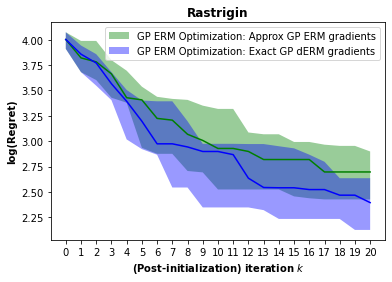

In [98]:
### Visualise!

title = func
plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, iters+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM Optimization: Approx GP ERM gradients')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP ERM Optimization: Exact GP dERM gradients')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialization) iteration $\it{k}$', weight = 'bold')
plt.ylabel('log(Regret)', weight = 'bold') 
plt.legend(loc=1) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show() #visualize!

In [99]:
time_approx, time_exact


(127.2826201915741, 228.38417434692383)